# `AA Workshop 9` — Coding Challenge

Complete the tasks below to practice implementing classification modeling from `W9_Trees_Ensembles.ipynb`.

Guidelines:
- Work in order. Run each cell after editing with Shift+Enter.
- Keep answers short; focus on making things work.
- If a step fails, read the error and fix it.

By the end you will have exercised:
- implementing a decision tree
- determining the optimal alpha to control overfitting
- plotting a tree

## Task 1 - Training a Generalizable Tree Classifier for Detecting Forged Banknotes

You are already familiar with the dataset containing data extracted from images that were taken from genuine and forged banknote-like specimens (raw data available as `BankNote_Authentication.csv` in the `data` directory; more information [here](https://archive.ics.uci.edu/dataset/267/banknote+authentication)). Let's train a decision tree classifier, and pay particular attention to the problem of overfitting by implementing a grid search over the identified effective alphas to determine where predictive performance is maximized. Do the following:
- load and inspect the data, then define your feature vector X (we only want to consider the features `variance` and `entropy`) and target Y (the `class`)
- perform a train-holdout-test split
- train a decision tree without a limit on the maximum depth, then compute the cost complexity pruning path
- calculate and plot the training vs. holdout accuracy for each effective alpha
- finally, plot the best performing tree and calculate the accuracy on the test set

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
np.set_printoptions(suppress=True)
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz

# load and inspect data
data = pd.read_csv("../data/BankNote_Authentication.csv")

data.head()

,variance,skewness,curtosis,entropy,class
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


In [2]:
# define x and y
X = np.array(data[["variance", "entropy"]])
Y = data['class'].values

In [3]:
# perform train-holdout-test split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, random_state=123)
x_train, x_hold, y_train, y_hold = train_test_split(x_train, y_train, test_size=(0.2/0.7), random_state=123)

print(len(x_train), len(x_hold), len(x_test))

# fit decision tree (without limit on max_depth, i.e. tree will grow fully if alpha is set to 0)
tree_classifier = DecisionTreeClassifier(random_state=0, 
                                         criterion="gini")

# compute cost_complexity_pruning_path 
path = tree_classifier.cost_complexity_pruning_path(x_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

685 275 412


In [4]:
scores_train = []
scores_hold = []

# run loop
for ccp_alpha in ccp_alphas:
    
    model = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    model.fit(x_train, y_train)    
    
    accuracy_train = accuracy_score(y_train, model.predict(x_train))
    accuracy_hold = accuracy_score(y_hold, model.predict(x_hold))
    scores_hold.append(accuracy_hold)
    scores_train.append(accuracy_train)
    
# collect results in DF
df = pd.DataFrame(columns=["alpha","train_score","holdout_score"])
df["alpha"]=ccp_alphas
df["train_score"] = scores_train
df["holdout_score"] = scores_hold

# show top five alphas
df.sort_values("holdout_score", ascending=False).head()

,alpha,train_score,holdout_score
17,0.001946,0.945985,0.894545
20,0.002165,0.940146,0.890909
18,0.002002,0.944526,0.890909
19,0.002159,0.944526,0.890909
31,0.008034,0.910949,0.890909


Optimal holdout accuracy of 0.89 at an alpha of 0.0019


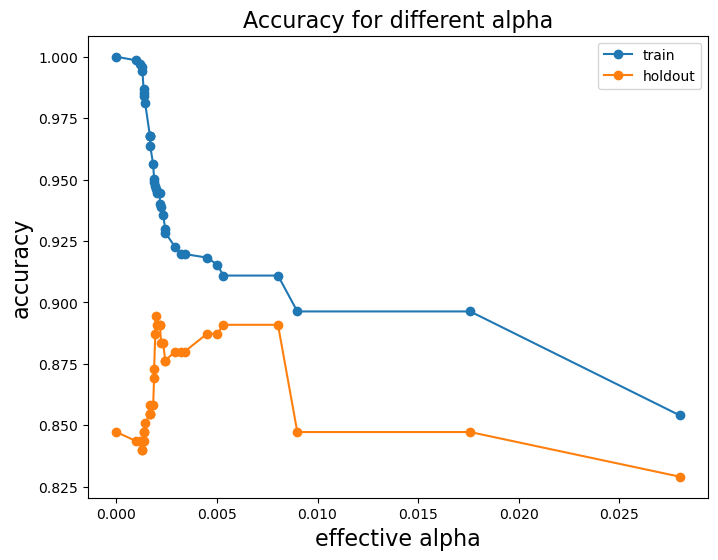

In [5]:
# sort df for plotting
df = df.sort_values("alpha",ascending=True)[:-1] # remove the last alpha as this corresponds to a tree with only the root node

print("Optimal holdout accuracy of", round(df.iloc[df.holdout_score.idxmax()].holdout_score,2), "at an alpha of", round(df.iloc[df.holdout_score.idxmax()].alpha,4))
plt.subplots(figsize=(8,6))
plt.plot(df["alpha"],df["train_score"], marker='o')
plt.plot(df["alpha"],df["holdout_score"], marker='o')
plt.legend(["train","holdout"])
plt.xlabel("effective alpha",fontsize=16)
plt.ylabel("accuracy",fontsize=16)
plt.title("Accuracy for different alpha",fontsize=16)
plt.show()

In [6]:
# calculate test accuracy
model = DecisionTreeClassifier(random_state=0, ccp_alpha=df.iloc[df.holdout_score.idxmax()].alpha)
model.fit(x_train, y_train)    
    
accuracy_test = accuracy_score(y_test, model.predict(x_test))
print("Test Accuracy:", round(accuracy_test, 2))

Test Accuracy: 0.88


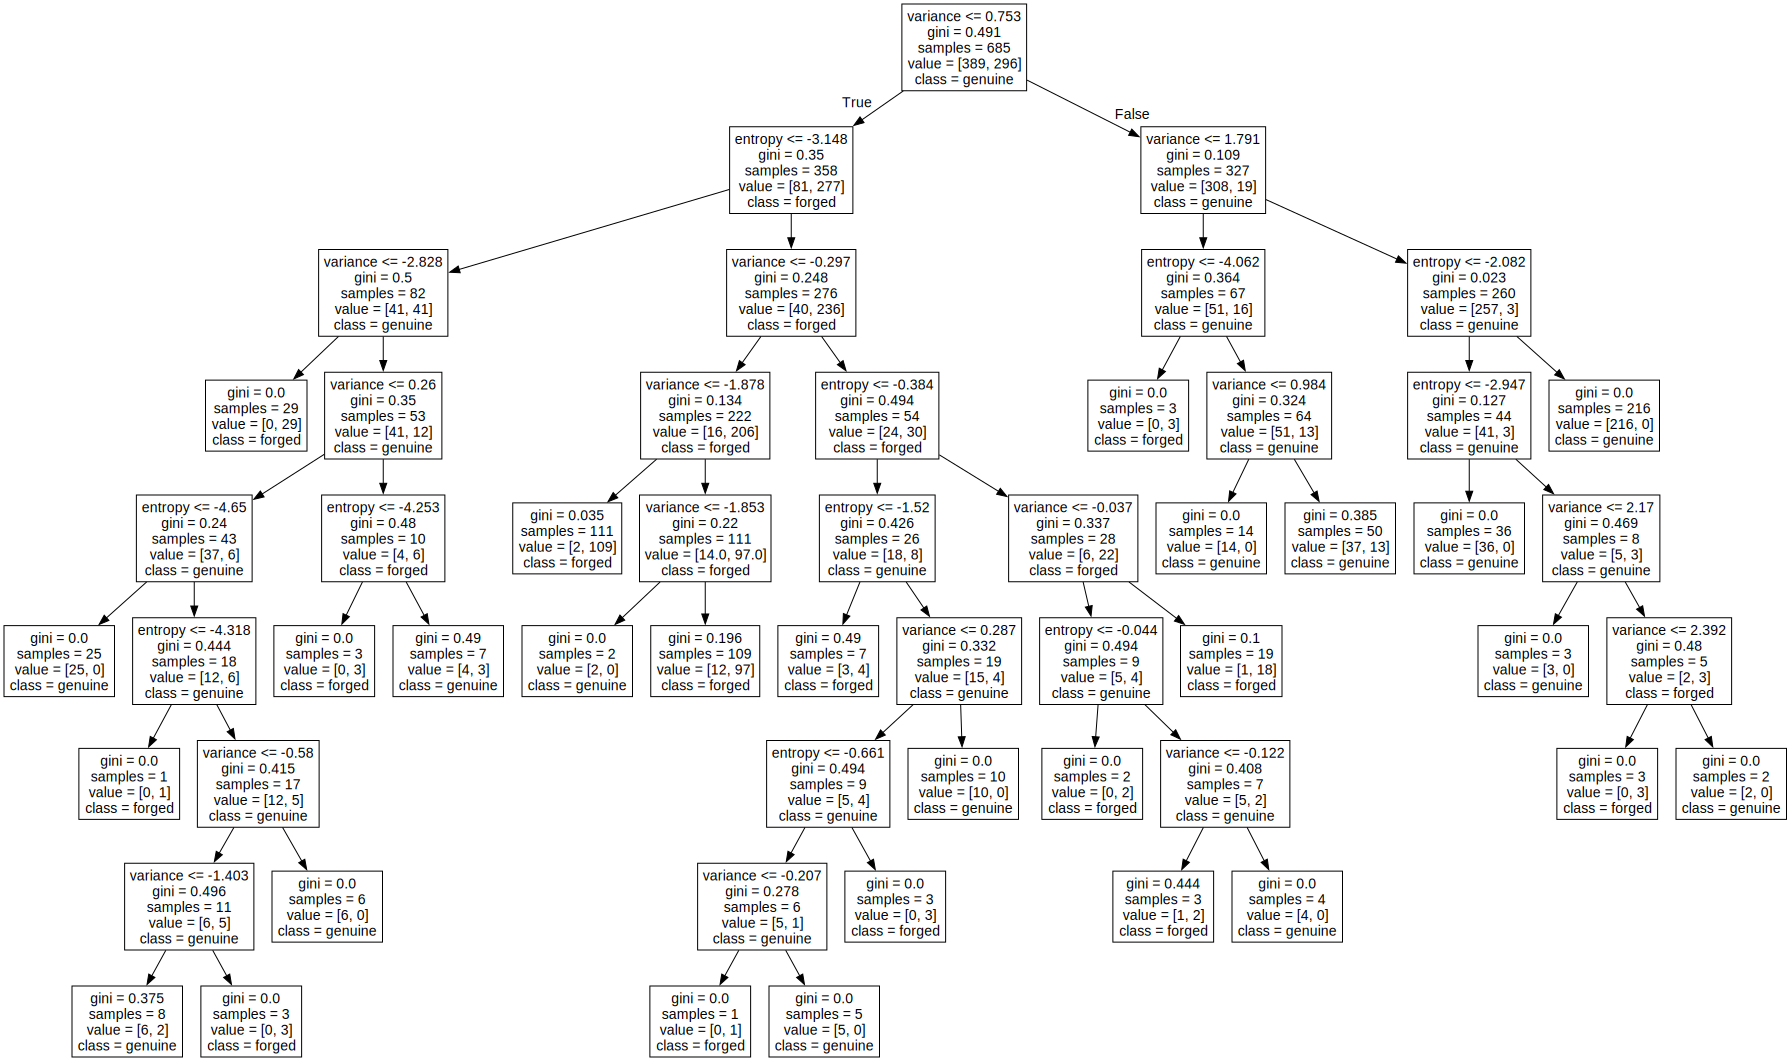

In [7]:
dot_data = export_graphviz(model,
                               feature_names=['variance','entropy'],
                              class_names = ["genuine","forged"],out_file=None)  
    
graph = graphviz.Source(dot_data) 
graph